# Stereo Rectification

Like eyes, we can use a stereo camera to perceive distance (i.e. depth information) of objects in the scene [3D
Viewer](http://www-personal.umich.edu/~xipengw/random/stereo-rectification.html). This is done by matching pixels from the same point in two images captured by two cameras. As shown in the image below, if we know two pixels (two small yellow balls on the cyan plane) are from the same yellow ball in 3D world, we can easily find the intersection point of two yellow lines.


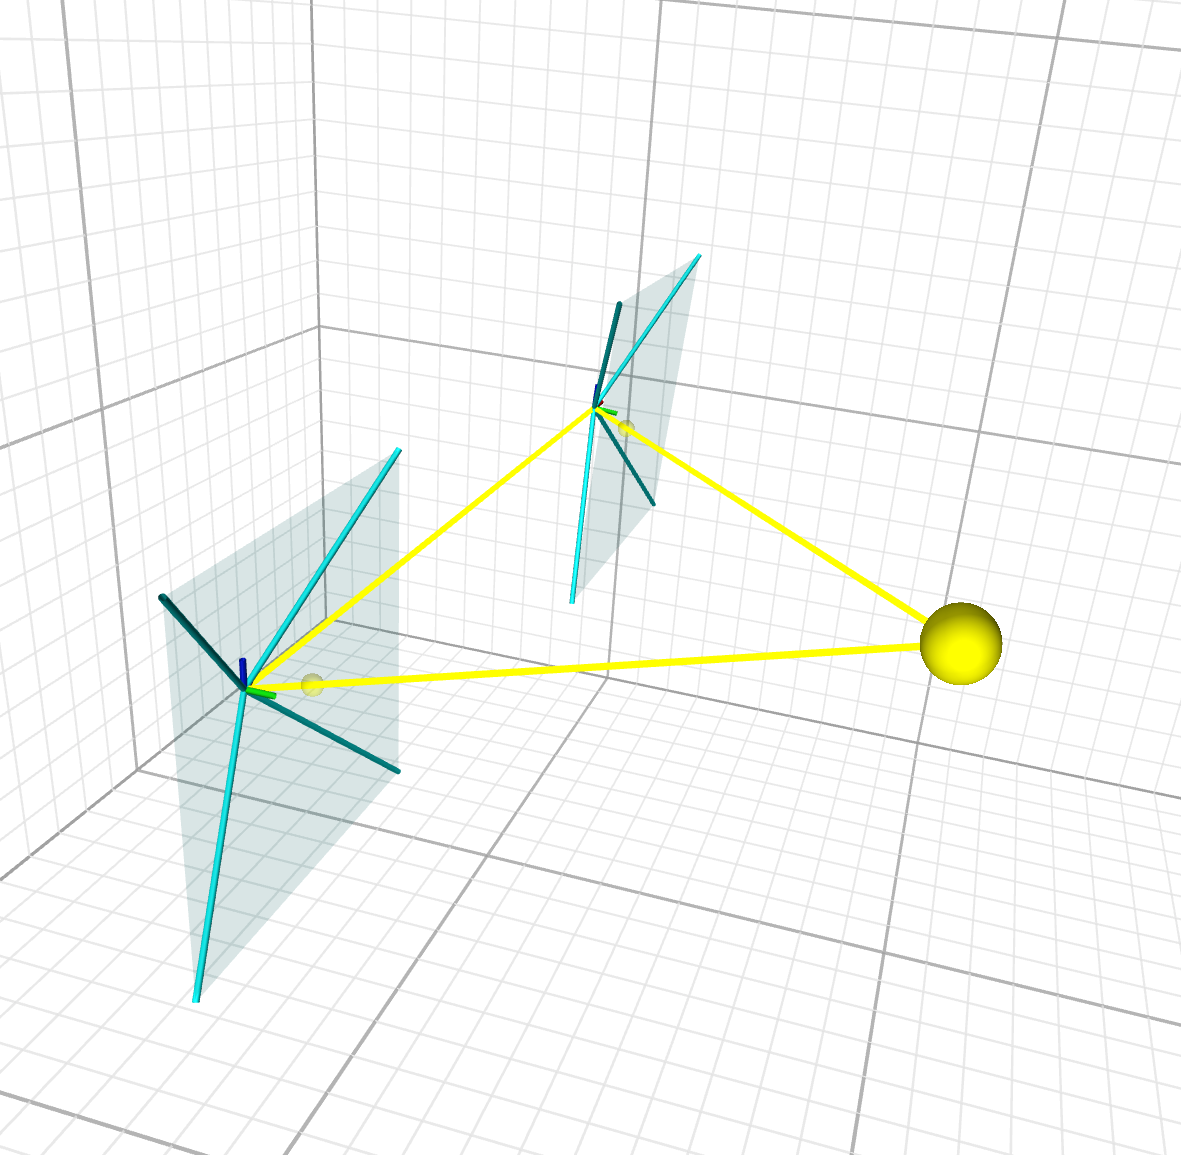

In [3]:
# Non-rectified stereo image
from IPython.display import Image
Image('../images/2021-01-09-stereo-rectification/non-rectify-stereo.png', width=300)
#

Normally we need to search on a 2D plane to find the matching pixels. However, if we know the relative position and orientation of two cameras, this is actually reduced to be a search just in 1D. It is because the left yellow line (i.e. ray) which points from the left camera to the yellow ball is projected as a line in the right image. Thus, we only need to search on this line to find the matching pixel to the yellow pixel in the left image. This line is called the epipolar line. If you play with the 3D viewer, you will see that this epipolar line is not parallel to camera x-axis. Matching process will be much easier if we can make the epipolar line parallel to the camera x-axis so that the matching pixels are always at the same row in the images (as shown in the image below). This is called stereo rectification.

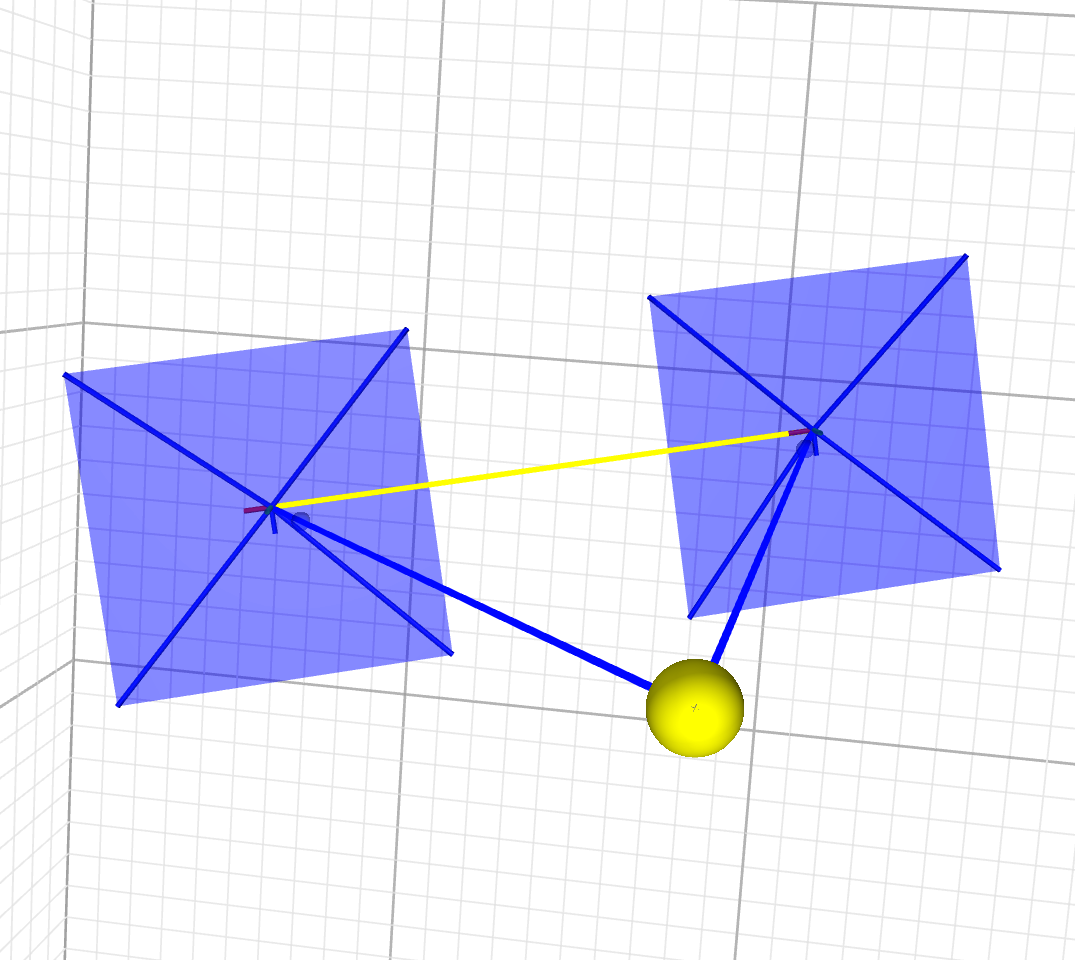

In [5]:
# Rectified stereo image
from IPython.display import Image
Image('../images/2021-01-09-stereo-rectification/rectify-stereo.png', width=300)
#

The idea is actually quite simple. I am trying to set two virtual cameras by purely rotating both left and right cameras to generate two virtual image plane shown as blue. They are virtual because the pixels in the virtual images are sampled from original images.

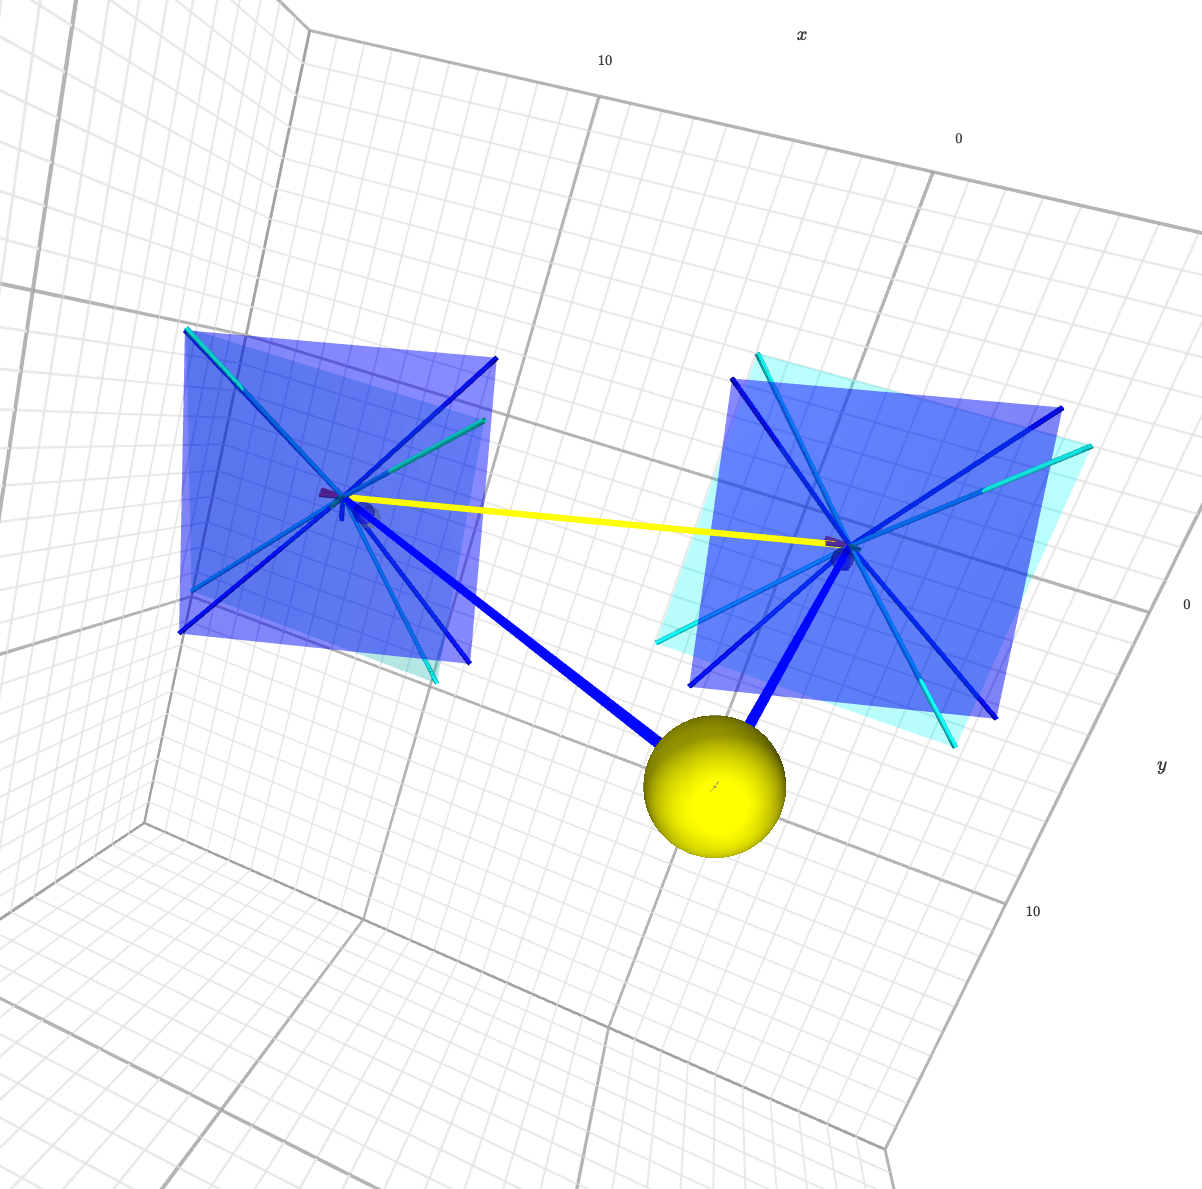

In [7]:
# Show both images
from IPython.display import Image
Image('../images/2021-01-09-stereo-rectification/both-cameras.png', width=300)
#

What are constraints that two virtual cameras have to satisfy? Firstly, there should be no relative orientation change between two cameras. Suppose originally the relative orientation is $R^l_r$, we can fix the left camera and rotate the right camera by ${R^l_r}^T$ to remove the relative orientation change. 

Secondly, the yellow line connecting two cameras should be parallel to both blue images, normally parallel to the x-axis of the cameras. 

We need to find a $R^{rect}_l$ to rotate both cameras. Finally the left camera is rotated by $R^{rect}_l$ and the right camera is rotated by $R^{rect}_lR^l_r$. For getting pixels for the virtual image, you need the homography equations below ($H^1_2 = R^1_2$).

> $$
\begin{bmatrix}
x_1\\
y_l \\
z_1
\end{bmatrix} =
R^1_2 \begin{bmatrix}
x_2\\
y_2 \\
z_2
\end{bmatrix}
$$
>
> $$
\begin{bmatrix}
u_1\\
v_l \\
1
\end{bmatrix} =
R^1_2 \begin{bmatrix}
u_2\\
v_2 \\
1
\end{bmatrix}
$$

**How does stereo rectification work when two cameras are mounted on top of each other not side by side?** If you **let the yellow line (displacement vector of two cameras) to be parallel to x-axes of the
cameras**, you will see virtual cameras rotate exactly 90 degrees when we actually already have a perfect setup of the stereo camera. The consequence is that you will see the world in virtual images are rotated 90 degrees as well. Here comes a quiz question: what can we change to make the images not rotated (hint: epipolar lines should be parallel to y-axes of the cameras)?

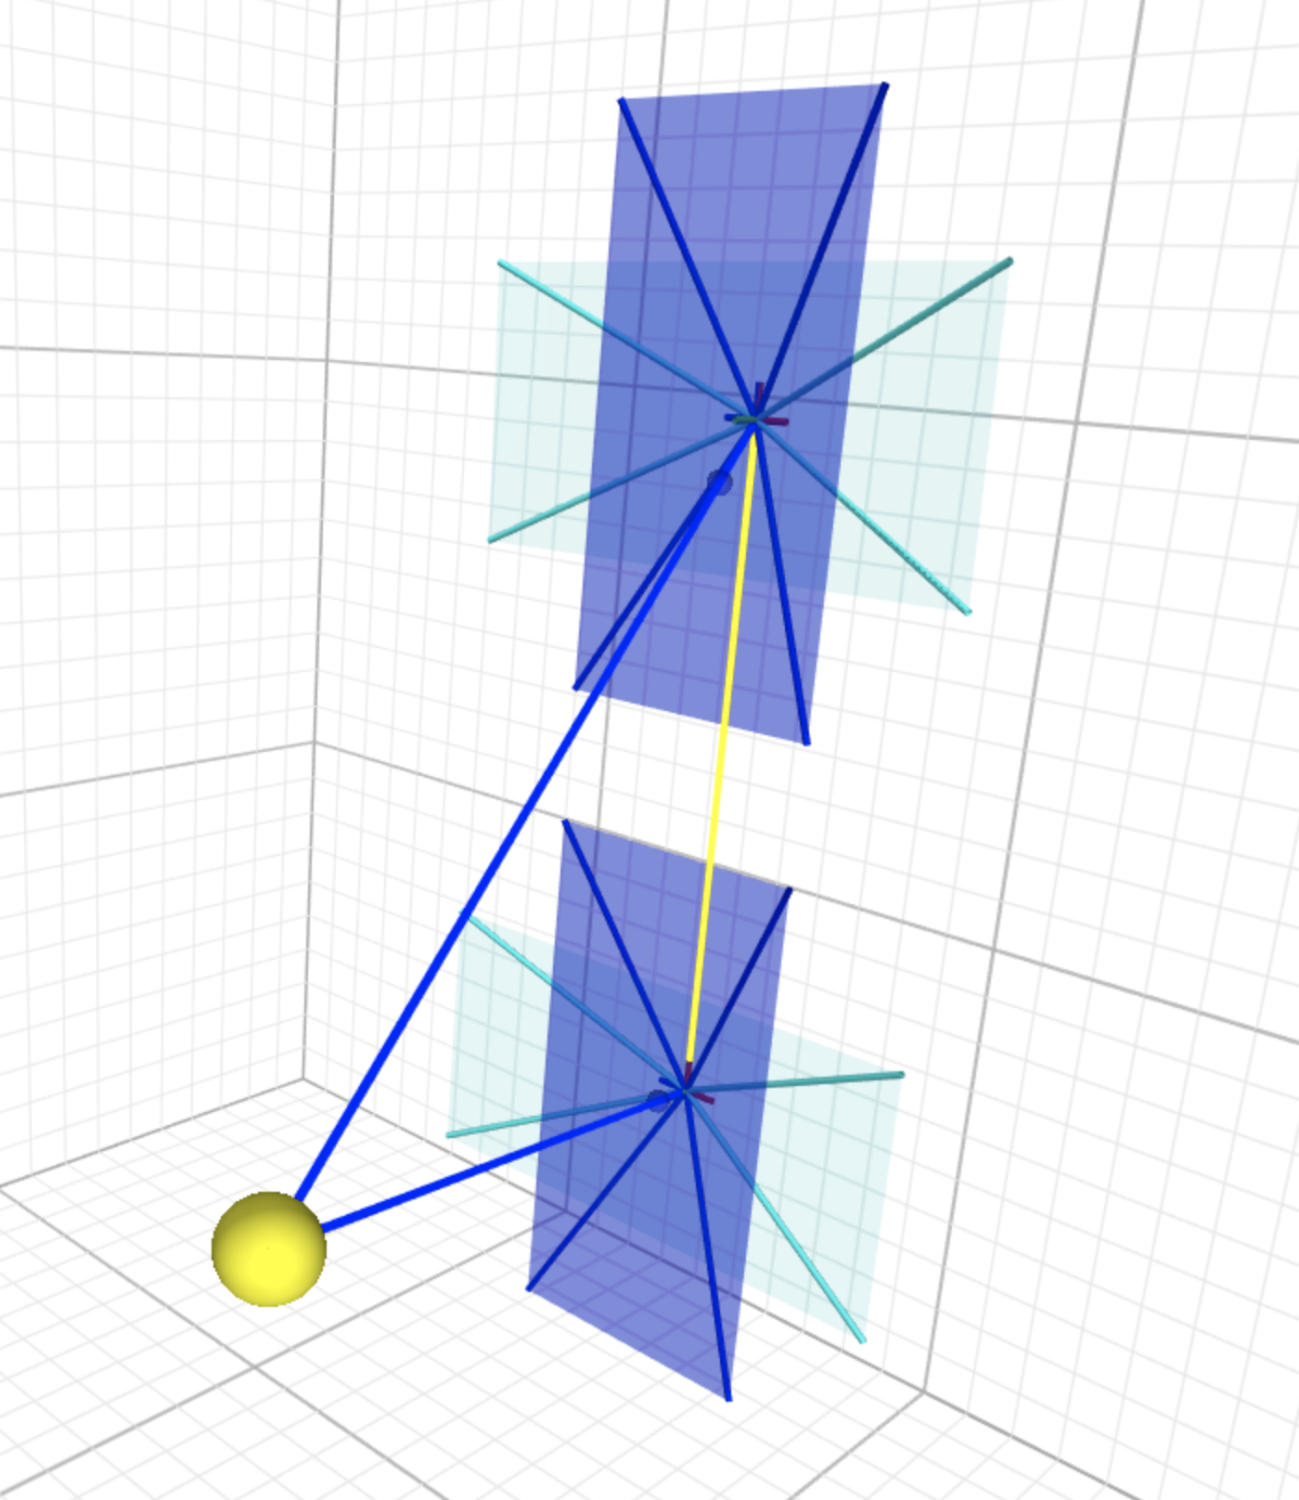

In [8]:
# Show both images
from IPython.display import Image
Image('../images/2021-01-09-stereo-rectification/v-cameras.png', width=300)
#

In [29]:
# Stereo rectification
import k3d
import k3d.platonic as platonic
import math
import numpy as np
from matplotlib.tri import Triangulation

plot = k3d.plot(camera_auto_fit=True, time=0.1)

K1 = np.array([[98, 0, 199],
              [0, 98, 198],
              [0, 0, 1]])
K1inv = np.linalg.inv(K1)
K2 = np.array([[102, 0, 198],
              [0, 102, 199],
              [0, 0, 1]])

K2inv = np.linalg.inv(K2)

P1 = np.array([2, 2, 10])

t12_1 = np.array([10, 0, 0])
# t12_1 = np.array([0, 10, 0]) # Vertical aligned cameras
r = 1* math.pi / 180
p = -20 * math.pi / 180
y = 1 * math.pi / 180
c = np.cos([r, p, y])
s = np.sin([r, p, y])
R12 = np.array([[1, 0, 0],
                [0, c[0], -s[0]],
                [0, s[0], c[0]]]).dot(
                    np.array([[c[1], 0, s[1]],
                              [0,      1,  0],
                              [-s[1],    0,  c[1]]])).dot(
                                  np.array([[c[2], -s[2], 0],
                                            [s[2], c[2], 0],
                                            [0, 0, 1]]))

uv1 = K1.dot(P1)
normalized_uv1 = uv1 / uv1[2]
uv1_c = K1inv.dot(normalized_uv1)
uv1_c = uv1_c / uv1_c[2]

P2 = np.transpose(R12).dot(P1) - np.transpose(R12).dot(t12_1)
# assert((R12.dot(P1)+t12_1 == P0).all())

uv2 = K2.dot(P2)
normalized_uv2 = uv2 / uv2[2]
uv2_c = K2inv.dot(normalized_uv2)
uv2_c = uv2_c / uv2_c[2]

class Camera():
    def __init__(self, plot, name, R, t, K, opacity=0.15, mesh_color=0x00ffff):
        self.plot = plot
        self.R = R
        self.t = t
        self.K = K
        self.name = name
        # plot things, like camera, normalized plane, etc.
        x_end = self.R.dot(np.array([0.5, 0., 0.]))
        x_axis = np.array([[self.t[0], self.t[1], self.t[2]], 
                            [self.t[0]+x_end[0], self.t[1]+x_end[1], self.t[2]+x_end[2]]])
        y_end = self.R.dot(np.array([0., 0.5, 0]))
        y_axis = np.array([[self.t[0], self.t[1], self.t[2]], 
                            [self.t[0]+y_end[0], self.t[1]+y_end[1], self.t[2]+y_end[2]]])
        z_end = self.R.dot(np.array([0., 0., 0.5]))
        z_axis = np.array([[self.t[0], self.t[1], self.t[2]], 
                            [self.t[0]+z_end[0], self.t[1]+z_end[1], self.t[2]+z_end[2]]])
        
        self.xplot = k3d.line(x_axis, shader='mesh', width=0.05, color=0xff0000, name=name+'_xaxis')
        self.yplot = k3d.line(y_axis, shader='mesh', width=0.05, color=0x0000ff, name=name+'_yaxis')
        self.zplot = k3d.line(z_axis, shader='mesh', width=0.05, color=0x00ff00, name=name+'_zaxis')
        xyz0 = self.t
        self.normalized_plane = k3d.line(
                np.stack((xyz0, xyz0+self.R.dot(np.array([4., 2., 1.])),
                          xyz0, xyz0+self.R.dot(np.array([-4., 2., 1.])),
                          xyz0, xyz0+self.R.dot(np.array([4., -2., 1.])),
                          xyz0, xyz0+self.R.dot(np.array([-4., -2., 1.]))), axis=0),
                shader='mesh', width=0.05, color=mesh_color,
            name=name+'_plane_frame')
        self.plot += self.xplot
        self.plot += self.yplot
        self.plot += self.zplot
        self.plot += self.normalized_plane
        
        x = np.array([0,4,4,-4,-4])
        y = np.array([0,2,-2,2,-2])
        z = np.array([1,1,1,1,1])
        points_xyz = self.R.dot(np.vstack([x,y,z])) + self.t.reshape(3,1)
        indices = Triangulation(x,y).triangles.astype(np.uint32)
        plt_mesh = k3d.mesh(points_xyz.T, indices, opacity=opacity, color=mesh_color, name=name+'_plane_mesh')
        self.plot += plt_mesh
  
plot += k3d.points(positions=P0, point_size=1, shader='3d', color=0xffff00, name='3D point')  
C1 = Camera(plot, 'C1', np.eye(3), np.zeros(3), K1)
C2 = Camera(plot, 'C2', R12, t12_1, K2)


def plot_camera_to_point_ray(camera, pt, opacity=0.4, mesh_color=0xffff00):
    camera.plot += k3d.line(np.stack((camera.t, pt), axis=0), width=0.1, color=mesh_color, 
                            name=camera.name+'ray_to_point')
    ray_C = np.transpose(camera.R).dot((pt - camera.t))
    ray_C /= ray_C[2]
    camera.plot += k3d.points(positions=camera.R.dot(ray_C)+camera.t, point_size=0.3, 
                              shader='3d', color=mesh_color, opacity=opacity, name=camera.name+'_intersection_pt')
   
def connect_c1_c2(c1, c2):
    c1.plot += k3d.line(np.stack((c1.t, c2.t), axis=0), width=0.1, color=0xffff00, name=c1.name+'To'+c2.name)
 
    
plot_camera_to_point_ray(C1, P1)
plot_camera_to_point_ray(C2, P1)
connect_c1_c2(C1, C2)

plot.display()
#

Output()

In [28]:
# Retification
def rectify(R12, t12_1, uv1_c, uv2_c, new_K1, new_K2):
    e1 = t12_1 / np.linalg.norm(t12_1)
    e2 = np.cross(np.array([0, 0, 1]), e1)
    e2 = e2 / np.linalg.norm(e2)
    e3 = np.cross(e1, e2)
    # When cameras are mounted side by side, rectified camera x-axis will be along 
    # the displacement direction as t12_1.
    R_1_rect = np.stack([e1, e2, e3], axis=1)
    # When cameras are mounted vertically, rectified camera y-axis will be along 
    # the displacement direction as t12_1.
    # R_1_rect = np.stack([e2, e1, e3], axis=1)
    R_rect_1 = np.transpose(R_1_rect)
    uv1_rect_c = R_rect_1.dot(uv1_c)
    uv1_rect_c = uv1_rect_c / uv1_rect_c[2]
    uv1_rect = new_K1.dot(uv1_rect_c)
    uv1_rect = uv1_rect / uv1_rect[2]
    uv2_rect_c = R_rect_1.dot(R12).dot(uv2_c)
    uv2_rect_c = uv2_rect_c / uv2_rect_c[2]
    uv2_rect = new_K2.dot(uv2_rect_c)
    uv2_rect = uv2_rect / uv2_rect[2]
    return (R_1_rect, uv1_rect_c, uv2_rect_c, uv1_rect, uv2_rect)


# new K1 is not necessary same as K1
new_K1 = np.array([[100, 0, 180],
                   [0, 100, 180],
                   [0, 0, 1]])

# new K2 is not necessary same as K1, but you want Hx, Hy to be same as ones in new_K1
new_K2 = np.array([[100, 0, 180],
                   [0, 100, 180],
                   [0, 0, 1]])

(R_1_rect, uv1_rect_c, uv2_rect_c, uv1_rect, uv2_rect) = rectify(R12, t12_1, uv1_c, uv2_c, new_K1, new_K2)

C1_rect = Camera(plot, 'C1_rect', R_1_rect, np.zeros(3), new_K1, 0.5, 0x0000ff)
C2_rect = Camera(plot, 'C2_rect', R_1_rect, t12_1, new_K2, 0.5, 0x0000ff)
plot_camera_to_point_ray(C1_rect, P0, 0.5, 0x0000ff)
plot_camera_to_point_ray(C2_rect, P0, 0.5, 0x0000ff)
connect_c1_c2(C1_rect, C2_rect)
#